# 📌 NYC Restaurant Inspection Risk Prediction

### 🧪 Exploratory Data Analysis

In this notebook, we will:

1. **Clean the Data**  
   - Apply the cleaning steps defined in `01_data_understanding.ipynb`, including value standardization, removal of inconsistencies, and column type corrections.  
   - Validate that the cleaned dataset is consistent and ready for downstream analysis.

2. **Split the Data**  
   - Perform a stratified train/validation/test split to preserve class balance and ensure unbiased model evaluation.
   - All subsequent analysis, including EDA and feature engineering decisions, will be based on the **training set only**.

3. **Generate Insights**  
   - Conduct exploratory data analysis (EDA) on the training set to identify patterns, trends, and relationships relevant to predicting `critical_flag`.  
   - Use visualizations and statistical tests to understand the feature-target relationships and detect potential signal or leakage.

4. **Guide Feature Engineering**  
   - Based on EDA findings, define new feature creation strategies to enhance model performance.  
   - Select an appropriate encoding approach for categorical variables to ensure compatibility with selected machine learning algorithms.


### Dependencies

In [1]:
import sys
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os.path import join, abspath
from folium.plugins import MarkerCluster

# adding the root folder to the system path
if abspath('..') not in sys.path:
    sys.path.append(abspath('..'))

from src.path_manager import PathManager
from src.data_cleaner import DataCleaner
import src.data_inspector as data_inspector

# path manager to handle paths
path_manager = PathManager()
raw_data_path = path_manager.raw_data_path
clean_data_path = path_manager.clean_data_path
plots_path = path_manager.plots_path

# set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/franco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/franco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Data

In [2]:
# feature types according to NYC open data portal
dtypes = {
    'camis': 'string',
    'dba': 'string',
    'boro': 'string',
    'building': 'string',
    'street': 'string',
    'zipcode': 'string',
    'phone': 'string',
    'cuisine_description': 'string',
    'action': 'string',
    'violation_code': 'string',
    'violation_description': 'string',
    'critical_flag': 'string',
    'score': 'float',
    'grade': 'string',
    'inspection_type': 'string',
    'latitude': 'float',
    'longitude': 'float',
    'community_board': 'string',
    'council_district': 'string',
    'census_tract': 'string',
    'bin': 'string',
    'bbl': 'string',
    'nta': 'string'
}

# date columns to parse
parse_dates = ['inspection_date', 'grade_date', 'record_date']

# import data
df = pd.read_csv(
    join(raw_data_path, 'nyc_rest_inspect.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    )

### Clean Data

In [3]:
# call datacleaner instance & clean data
cleaner = DataCleaner(df)
clean_df = cleaner.clean_data()

clean_df.head(5)

reducing cardinality: 100%|██████████| 10/10 [00:00<00:00, 289.52col/s]


,camis,dba,boro,building,street,zipcode,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,inspection_type,latitude,longitude,inspection_id
key,,,,,,,,,,,,,,,,,,
50170333_28-05-25_05F,50170333,Enerugi Ramen,Brooklyn,224,Atlantic Avenue,11201,Other,2025-05-28,Violations were cited in the following area(s).,05F,insufficient hot holding cold storage cold hol...,Critical,28.0,C,Other,40.689444,-73.991678,50170333_28-05-25
50170071_27-05-25_05F,50170071,Tropicalfete,Brooklyn,850,New York Avenue,11203,Other,2025-05-27,Violations were cited in the following area(s).,05F,insufficient hot holding cold storage cold hol...,Critical,127.0,C,Other,40.653096,-73.946918,50170071_27-05-25
50170013_20-05-25_06D,50170013,Omiya Sushi,Brooklyn,8618,4 Avenue,11209,Other,2025-05-20,Violations were cited in the following area(s).,06D,food contact surface properly washed rinsed sa...,Critical,10.0,A,Pre-permit (Operational) / Initial Inspection,40.622597,-74.028443,50170013_20-05-25
50169948_28-05-25_10F,50169948,Trelawny Spice,Bronx,1438,East Gun Hill Road,10469,Other,2025-05-28,Violations were cited in the following area(s).,10F,non food contact surface equipment made unacce...,Not Critical,11.0,A,Other,40.869463,-73.844341,50169948_28-05-25
50169948_28-05-25_08A,50169948,Trelawny Spice,Bronx,1438,East Gun Hill Road,10469,Other,2025-05-28,Violations were cited in the following area(s).,08A,establishment free harborage condition conduci...,Not Critical,11.0,A,Other,40.869463,-73.844341,50169948_28-05-25


### Sanitary Check

In [4]:
# check for missing values
print(f'The data has now a total of {clean_df.isna().sum().sum()} missing values.')

The data has now a total of 0 missing values.


In [5]:
# check for duplicates
tmp = clean_df.copy().reset_index()
check_key_dup = len(tmp[tmp.duplicated(subset='key', keep=False)])
check_full_dup = len(clean_df[clean_df.duplicated(keep=False)])

print(f'Data has {check_key_dup} key duplicates.')
print(f'Data has {check_full_dup} full duplicates.')

Data has 0 key duplicates.
Data has 0 full duplicates.


In [6]:
# check health code presence
mask_no_letters = clean_df['violation_code'].str.match(r'^[^A-Za-z]+$') # mask for codes with no letters
no_letter_subset = clean_df.loc[mask_no_letters, ['violation_code']]
codes_without_letters = list(set(no_letter_subset['violation_code'].values))

print(f'There are {len(codes_without_letters)} observation with health codes instead of violation codes.\n')

There are 0 observation with health codes instead of violation codes.



| DOHMH Grade | Score Range | Interpretation       |
|-------------|-------------|----------------------|
| A           | 0–13        | Low Risk             |
| B           | 14–27       | Moderate Risk        |
| C           | 28+         | High Risk            |
| N, Z, P     | —           | Not Graded / Pending |

In [About NYC Inspection Data](https://data.cityofnewyork.us/api/views/43nn-pn8j/files/0658bb14-1b0a-4fc6-b389-d42ae6e9d3be?download=true&filename=About_NYC_Restaurant_Inspection_Data_on_NYC_OpenData_050222.docx), is stated that *"The Health Department conducts non-gradable inspections to enforce Special Programs..."*, meaning that there are instances with `score` but they are be non-gradable.

In [7]:
# check score range per grade & compare with DOHMH ranges
grade_score = clean_df.groupby('grade')['score'].agg(['count', 'min', 'max', 'mean']).reset_index()
print('Score range per grade:')
display(grade_score)

Score range per grade:


,grade,count,min,max,mean
0,A,33324,0.0,13.0,9.983645
1,B,8390,14.0,27.0,22.118594
2,C,5921,28.0,168.0,44.141023
3,Non-gradable,45472,0.0,168.0,32.911660


In [8]:
# check for restaurants with different names or streets (confirms normalization was successful on these features)
check_dba_norm = len(clean_df.groupby('camis')['dba'].nunique().reset_index(name='n_unique').query('n_unique > 1'))
check_street_norm = len(clean_df.groupby('camis')['street'].nunique().reset_index(name='n_unique').query('n_unique > 1'))
print(f'There are {check_dba_norm} restaurants with multiple names.')
print(f'There are {check_street_norm} restaurants with multiple street names.')

There are 0 restaurants with multiple names.
There are 0 restaurants with multiple street names.


In [9]:
# check if all cuisine_description categories have at least 4% of proportion
check_cuisine_prop = clean_df.cuisine_description.value_counts(normalize=True).reset_index()
check_cuisine_prop.proportion *= 100
display(check_cuisine_prop.round(2))

,cuisine_description,proportion
0,Other,52.17
1,American,16.18
2,Chinese,10.02
3,Coffee/Tea,6.92
4,Pizza,6.31
5,Latin American,4.4
6,Mexican,4.01


In [10]:
# check critical flags proportion
critical_flags = clean_df.critical_flag.value_counts(normalize=True).reset_index()
critical_flags.proportion *= 100
print('Critical flags proportion:')
display(critical_flags.round(2))

Critical flags proportion:


,critical_flag,proportion
0,Critical,57.2
1,Not Critical,42.8


In [11]:
# checking violation descriptions after normalization
code_desc = clean_df.groupby('violation_code', as_index=False)['violation_description'].nunique().sort_values(by='violation_description', ascending=False)

code_desc = code_desc.loc[code_desc['violation_description'] > 1].reset_index(drop=True)

print(f'There are {code_desc.shape[0]} violation codes with multiple descriptions.\n\n')
top_5_codes = list(code_desc.iloc[:5].violation_code)
top_5_codes_desc = clean_df.loc[clean_df.violation_code.isin(top_5_codes), ['violation_code', 'violation_description']].drop_duplicates()

for code in top_5_codes:
    code_subset = top_5_codes_desc[top_5_codes_desc['violation_code'] == code].reset_index(drop=True)
    desc = code_subset[['violation_description']]
    print(f'Violation code: {code}')
    display(desc.style)
    print('\n')

There are 45 violation codes with multiple descriptions.


Violation code: 05C


,violation_description
0,food contact surface refillable reusable container equipment improperly constructed placed maintained unacceptable material used culinary sink acceptable method provided washing food
1,design construction material used maintenance food contact surface improper surface easily cleanable sanitized maintained culinary sink acceptable method provided washing food
2,food contact surface improperly constructed located unacceptable material used




Violation code: 05H


,violation_description
0,approved written standard operating procedure avoiding contamination refillable returnable container
1,written standard operating procedure sop approved department refillable reusable container available time inspection container construction improper
2,facility available wash rinse sanitize utensil equipment




Violation code: 06C


,violation_description
0,food supply equipment protected potential source contamination storage preparation transportation display service customer refillable reusable container condiment single service container dispensed directly vendor
1,food supply equipment protected potential source contamination storage preparation transportation display service
2,food protected potential source contamination storage preparation transportation display service




Violation code: 02A


,violation_description
0,time temperature control safety tc food cooked required minimum internal temperature poultry poultry part ground comminuted poultry stuffing containing poultry meat fish ratite second interruption cooking process ground meat food containing ground comminuted meat second interruption cooking process except per individual customer request pork food containing pork second mechanically tenderized injected meat whole meat roast beef steak required temperature time except per individual customer request raw animal food cooked microwave covered rotated stirred food second shell egg second except per individual customer request
1,food cooked required minimum temperature




Violation code: 04N


,violation_description
0,filth fly food refuse sewage associated frsa fly nuisance pest establishment food non food area frsa fly include house fly blow fly bottle fly flesh fly drain fly phorid fly fruit fly
1,filth fly food refuse sewage associated frsa fly present facility food non food area filth fly include house fly little house fly blow fly bottle fly flesh fly food refuse sewage associated fly include fruit fly drain fly phorid fly


- Less violation codes with distinct descriptions but there are still 45, however they share simmilarities in text, with some containing more details.

### Data Split

- After data cleaning, the dataset is set up for a **binary classification task** on `critical_flag`. 
The "Not Applicable" class was unintentionally filtered out, this label likely corresponded to **irregular or incomplete inspection records**.

- The dataset is structured at the **violation-per-inspection** level, with `inspection_date` introducing a **temporal dimension**.

- The train/test/validation split strategy must account for this structure to ensure both **temporal realism** and **label distribution integrity**.

- The split strategy will start by following a **70/15/15 proportion** for train, validation, and test sets, respectively, while accounting for label distribution and inspection grouping.

**📌 Split Rules**

1. **Group-level Isolation**: All rows sharing the same `inspection_id` must be assigned to the **same split** to avoid data leakage from overlapping inspections.
2. **Temporal Holdout**: The **most recent inspections**, as ordered by `inspection_date`, should form the **validation/test sets** to simulate a realistic future prediction scenario.
3. **Stratified Sampling**: The `critical_flag` distribution should be **preserved across splits** to ensure consistent label proportions.

In [12]:
def custom_temporal_split(df, test_size=0.15, val_size=0.15, random_state=42):
    '''
    Custom split function that maintains temporal order and group integrity.
    
    Args:
        df (pd.DataFrame): Input dataframe
        test_size (float): Proportion of data for test set
        val_size (float): Proportion of data for validation set
        random_state (int): Random seed for reproducibility
        
    Returns:
        train_df, val_df, test_df (tuple): Split dataframes
    '''
    # Sort by inspection date to ensure temporal order
    df_sorted = df.sort_values('inspection_date')
    
    # Get unique inspection_ids to maintain group integrity
    unique_inspections = df_sorted['inspection_id'].unique()
    n_inspections = len(unique_inspections)
    
    # Calculate split points based on inspection counts
    n_test = int(n_inspections * test_size)
    n_val = int(n_inspections * val_size)
    
    # Split inspection IDs while maintaining temporal order
    test_inspections = unique_inspections[-n_test:]  # Most recent for test
    val_inspections = unique_inspections[-(n_test + n_val):-n_test]  # Second most recent for val
    train_inspections = unique_inspections[:-(n_test + n_val)]  # Remaining for train
    
    # Create masks for each split
    test_mask = df_sorted['inspection_id'].isin(test_inspections)
    val_mask = df_sorted['inspection_id'].isin(val_inspections)
    train_mask = df_sorted['inspection_id'].isin(train_inspections)
    
    # Split the data
    test_df = df_sorted[test_mask].copy()
    val_df = df_sorted[val_mask].copy()
    train_df = df_sorted[train_mask].copy()
    
    # Verify critical_flag distribution
    print('\nClass distribution in splits:')
    print('\nTrain set:')
    display(train_df['critical_flag'].value_counts(normalize=True).mul(100).reset_index(name='perc').round(2))
    print('\nValidation set:')
    display(val_df['critical_flag'].value_counts(normalize=True).mul(100).reset_index(name='perc').round(2))
    print('\nTest set:')
    display(test_df['critical_flag'].value_counts(normalize=True).mul(100).reset_index(name='perc').round(2))
    
    return train_df, val_df, test_df

In [13]:
# Apply the custom split
train_df, val_df, test_df = custom_temporal_split(clean_df, test_size=0.15, val_size=0.15, random_state=RANDOM_STATE)

# get split size percentages
split_size_check_dict = {
    'train':   {'perc': np.round(len(train_df)/len(clean_df)*100, 1)},
    'val':     {'perc': np.round(len(val_df)/len(clean_df)*100, 1)},
    'test':    {'perc': np.round(len(test_df)/len(clean_df)*100, 1)}
}
split_size_check_df = pd.DataFrame(split_size_check_dict)
print('\nSplit sizes:')
display(split_size_check_df.T.round(2))

# check temporal ordering
temporal_check_dict = {
    'train':    {'min': train_df['inspection_date'].min(), 'max': train_df['inspection_date'].max()},
    'val':      {'min': val_df['inspection_date'].min(), 'max': val_df['inspection_date'].max()},
    'test':     {'min': test_df['inspection_date'].min(), 'max': test_df['inspection_date'].max()}
}
temporal_check_df = pd.DataFrame(temporal_check_dict)
print('\nDate ranges for each split:')
display(temporal_check_df.T.round(2))

# confirm group integrity
print('\nChecking group integrity...')
all_inspection_ids = set(clean_df['inspection_id'].unique())
split_inspection_ids = set(train_df['inspection_id'].unique()) | set(val_df['inspection_id'].unique()) | set(test_df['inspection_id'].unique())
assert len(all_inspection_ids) == len(split_inspection_ids), 'Some inspection_ids were lost in the split!'

# Check for overlaps
train_ids = set(train_df['inspection_id'].unique())
val_ids = set(val_df['inspection_id'].unique())
test_ids = set(test_df['inspection_id'].unique())

assert len(train_ids & val_ids) == 0, 'Overlap found between train and validation sets!'
assert len(train_ids & test_ids) == 0, 'Overlap found between train and test sets!'
assert len(val_ids & test_ids) == 0, 'Overlap found between validation and test sets!'

print('✅ All integrity checks passed!')


Class distribution in splits:

Train set:


,critical_flag,perc
0,Critical,57.48
1,Not Critical,42.52



Validation set:


,critical_flag,perc
0,Critical,57.09
1,Not Critical,42.91



Test set:


,critical_flag,perc
0,Critical,56.09
1,Not Critical,43.91



Split sizes:


,perc
train,69.0
val,15.5
test,15.5



Date ranges for each split:


,min,max
train,2015-09-24,2024-07-02
val,2024-07-02,2024-12-12
test,2024-12-12,2025-05-31



Checking group integrity...
✅ All integrity checks passed!


In [14]:
# check restaurant overlap between splits
train_restaurants = set(train_df['camis'].unique())
val_restaurants = set(val_df['camis'].unique())
test_restaurants = set(test_df['camis'].unique())

# validation set
val_seen = val_restaurants & train_restaurants
val_unseen = val_restaurants - train_restaurants
print('\nValidation Set Restaurant Analysis:')
print(f'Total restaurants in validation: {len(val_restaurants)}')
print(f'Previously seen in training: {len(val_seen)} ({len(val_seen)/len(val_restaurants):.1%})')
print(f'New restaurants: {len(val_unseen)} ({len(val_unseen)/len(val_restaurants):.1%})')

# test set
test_seen = test_restaurants & train_restaurants
test_unseen = test_restaurants - train_restaurants
print('\nTest Set Restaurant Analysis:')
print(f'Total restaurants in test: {len(test_restaurants)}')
print(f'Previously seen in training: {len(test_seen)} ({len(test_seen)/len(test_restaurants):.1%})')
print(f'New restaurants: {len(test_unseen)} ({len(test_unseen)/len(test_restaurants):.1%})')

# more statistics
print('\nOverall Restaurant Coverage:')
print(f"Total unique restaurants in dataset: {len(set(clean_df['camis'].unique()))}")
print(f"Restaurants in training: {len(train_restaurants)} ({len(train_restaurants)/len(set(clean_df['camis'].unique())):.1%})")
print(f'Restaurants appearing in multiple splits: {len(train_restaurants & (val_restaurants | test_restaurants))}')


Validation Set Restaurant Analysis:
Total restaurants in validation: 7629
Previously seen in training: 5593 (73.3%)
New restaurants: 2036 (26.7%)

Test Set Restaurant Analysis:
Total restaurants in test: 7221
Previously seen in training: 4998 (69.2%)
New restaurants: 2223 (30.8%)

Overall Restaurant Coverage:
Total unique restaurants in dataset: 24316
Restaurants in training: 20410 (83.9%)
Restaurants appearing in multiple splits: 9241


In [15]:
# save clean splits
train_df.to_csv(join(clean_data_path,'clean_train.csv'))
val_df.to_csv(join(clean_data_path,'clean_val.csv'))
test_df.to_csv(join(clean_data_path,'clean_test.csv'))

### EDA

In [16]:
# create geodataframe 
gdf = gpd.GeoDataFrame(
    train_df,
    geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude),
    crs='EPSG:4326'  # WGS84
)

gdf.head()

,camis,dba,boro,building,street,zipcode,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,inspection_type,latitude,longitude,inspection_id,geometry
key,,,,,,,,,,,,,,,,,,,
40944945_24-09-15_10B,40944945,Stage 42,Manhattan,422,West 42 Street,10036,American,2015-09-24,Establishment re-opened by DOHMH.,10B,plumbing properly installed maintained anti si...,Not Critical,2.0,A,Other,40.758823,-73.993607,40944945_24-09-15,POINT (-73.99361 40.75882)
50015538_19-11-15_10B,50015538,American Airlines Theater,Manhattan,227,West 42 Street,10036,American,2015-11-19,Violations were cited in the following area(s).,10B,plumbing properly installed maintained anti si...,Not Critical,12.0,A,Cycle Inspection / Initial Inspection,40.756531,-73.988117,50015538_19-11-15,POINT (-73.98812 40.75653)
50015171_20-11-15_10F,50015171,New Amsterdam Theater,Manhattan,214,West 42 Street,10036,American,2015-11-20,Violations were cited in the following area(s).,10F,non food contact surface improperly constructe...,Not Critical,10.0,A,Cycle Inspection / Initial Inspection,40.756317,-73.987652,50015171_20-11-15,POINT (-73.98765 40.75632)
50041177_21-01-16_10H,50041177,Firstlive Studio,Brooklyn,219,Central Avenue,11221,Other,2016-01-21,Violations were cited in the following area(s).,10H,proper sanitization provided utensil ware wash...,Not Critical,6.0,A,Cycle Inspection / Initial Inspection,40.697359,-73.923881,50041177_21-01-16,POINT (-73.92388 40.69736)
50041177_21-01-16_10E,50041177,Firstlive Studio,Brooklyn,219,Central Avenue,11221,Other,2016-01-21,Violations were cited in the following area(s).,10E,accurate thermometer provided refrigerated hot...,Not Critical,6.0,A,Cycle Inspection / Initial Inspection,40.697359,-73.923881,50041177_21-01-16,POINT (-73.92388 40.69736)


In [17]:
# check restaurants locations
tmp = gdf.copy()
tmp = tmp[(tmp['latitude'].abs() >= 0.01) & (tmp['longitude'].abs() >= 0.01)]
tmp = tmp.sort_values(['dba', 'inspection_date'], ascending=False)
tmp_2 = tmp.copy()
tmp_3 = tmp.copy()

tmp_grouped = tmp.groupby('camis', as_index=False)[['dba', 'cuisine_description', 'latitude', 'longitude', 'grade', 'inspection_date', 'geometry']].first()
tmp_grouped_2 = tmp_2.groupby('camis', as_index=False)[['score']].mean() # average score
tmp_grouped = tmp_grouped.merge(tmp_grouped_2, on='camis', how='left')

# create map
avg_lat, avg_long = tmp_grouped['latitude'].mean(), tmp_grouped['longitude'].mean()
m = folium.Map(location=[avg_lat, avg_long], zoom_start=11, tiles='OpenStreetMap')
marker_cluster = MarkerCluster().add_to(m)
for _, row in tmp_grouped.iterrows(): # add markers to map
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"""
            <div style="width: 300px;">
                <strong>Restaurant:</strong> {row['dba']}<br>
                <strong>Cuisine:</strong> {row['cuisine_description']}<br>
                <strong>Avg Score:</strong> {row['score']}<br>
                <strong>Most Recent Grade:</strong> {row['grade']}<br>
                <strong>Most Recent Inspection:</strong> {row['inspection_date'].strftime('%Y-%m-%d')}
            </div>
        """,
        tooltip=row['dba']
    ).add_to(marker_cluster)

# save map html
map_path = join(plots_path, 'restaurants_map.html')
m.save(map_path)
print(f'Map saved to: {map_path}')

Map saved to: /Users/franco/Desktop/PMI_Case_Study/plots/restaurants_map.html


In [18]:
# drop latitude and longitude now that we have a geodataframe
if all(col in gdf.columns for col in ['latitude', 'longitude']):
    gdf = gdf.drop(columns=['latitude', 'longitude'])

# inspect data
di = data_inspector.DataInspector(gdf)

# inspect data general info and summary statistics
df_info_describe = di.inspect()
display(df_info_describe)

# count features per data type 
display(di.count_types())


Data types, Missing values, and Summary statistics:


,type,NA Count,NA %,mean,min,25%,50%,75%,max,std,unique,top,freq
inspection_date,datetime64[ns],0,0.0,2023-03-01 15:03:13.871138560,2015-09-24 00:00:00,2022-08-01 00:00:00,2023-03-20 00:00:00,2023-12-01 00:00:00,2024-07-02 00:00:00,-,-,-,-
score,float64,0,0.0,23.12,0.0,12.0,19.0,31.0,168.0,17.33,-,-,-
geometry,geometry,0,0.0,-,-,-,-,-,-,-,-,-,-
violation_description,object,0,0.0,-,-,-,-,-,-,-,112,non food contact surface equipment made unacce...,7423
inspection_id,object,0,0.0,-,-,-,-,-,-,-,38553,50138297_03-08-23,11
inspection_type,string,0,0.0,-,-,-,-,-,-,-,4,Cycle Inspection / Initial Inspection,37242
grade,string,0,0.0,-,-,-,-,-,-,-,4,Non-gradable,32932
critical_flag,string,0,0.0,-,-,-,-,-,-,-,2,Critical,36949
violation_code,string,0,0.0,-,-,-,-,-,-,-,65,10F,9478
camis,string,0,0.0,-,-,-,-,-,-,-,20410,50040296,19



Count of features per data type:


,string,object,datetime64[ns],float64,geometry
count,12,2,1,1,1


In [19]:
# how many times each violation code is marked as either critical or not critical
violation_crit_count = len(
    gdf.groupby('violation_code')['critical_flag']
    .nunique()
    .reset_index(name='n_unique')
    .query('n_unique > 1')
)

print(f'{violation_crit_count} violation code(s) can be either critical or not critical.')

1 violation code(s) can be either critical or not critical.


**Takeaways**:

- Only 1 metric feature at the moment. 

- The mapping between `violation_code` and `critical_flag` is nearly deterministic — only one `violation_code` appears with both `Critical` and `Not Critical` labels. Including it may cause the model to overfit by memorizing codes rather than learning broader patterns. While violation codes are useful for rule-based insights, we **test two scenarios: with and without `violation_code`. If it's overly dominant, we'll prioritize the model without it for better generalization and to uncover patterns in other features**.


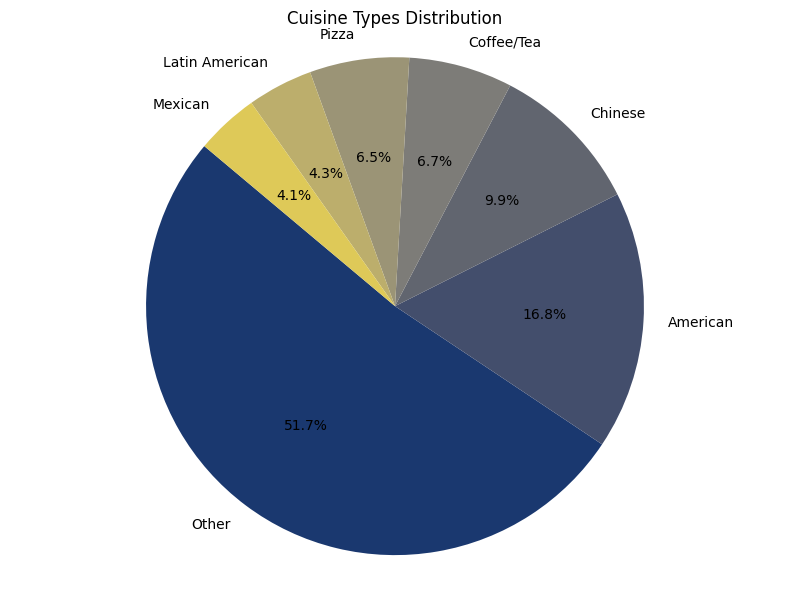

In [20]:
cuisine_counts = gdf['cuisine_description'].value_counts().reset_index()
cuisine_counts.columns = ['cuisine_description', 'count']

# Plot as pie chart with percentages
plt.figure(figsize=(8, 6))
plt.pie(
    cuisine_counts['count'],
    labels=cuisine_counts['cuisine_description'],
    autopct='%1.1f%%',
    colors=sns.color_palette('cividis', len(cuisine_counts)),
    startangle=140
)
plt.title('Cuisine Types Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

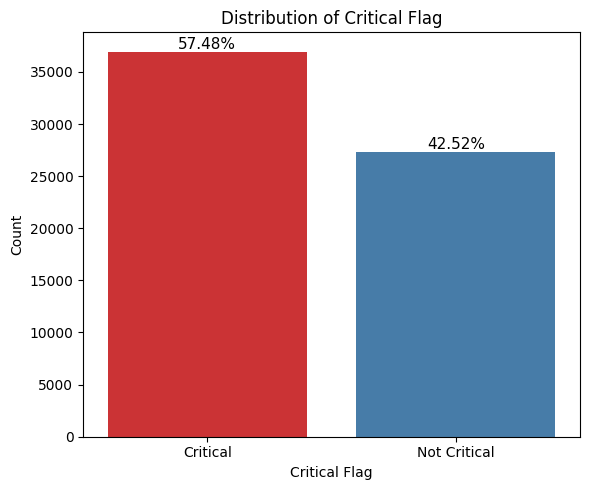

In [21]:
# Prepare data
df_crit = gdf['critical_flag'].value_counts().reset_index()
df_crit.columns = ['critical_flag', 'count']
df_crit['percentage'] = (df_crit['count'] / df_crit['count'].sum() * 100).round(2)

# Plot
plt.figure(figsize=(6, 5))
barplot = sns.barplot(data=df_crit, x='critical_flag', y='count', hue='critical_flag', palette='Set1')

# Add text annotations for percentages
for i, row in df_crit.iterrows():
    barplot.text(
        x=i, y=row['count'] + 5, 
        s=f"{row['percentage']}%", 
        ha='center', va='bottom', fontsize=11
    )

plt.title('Distribution of Critical Flag')
plt.xlabel('Critical Flag')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

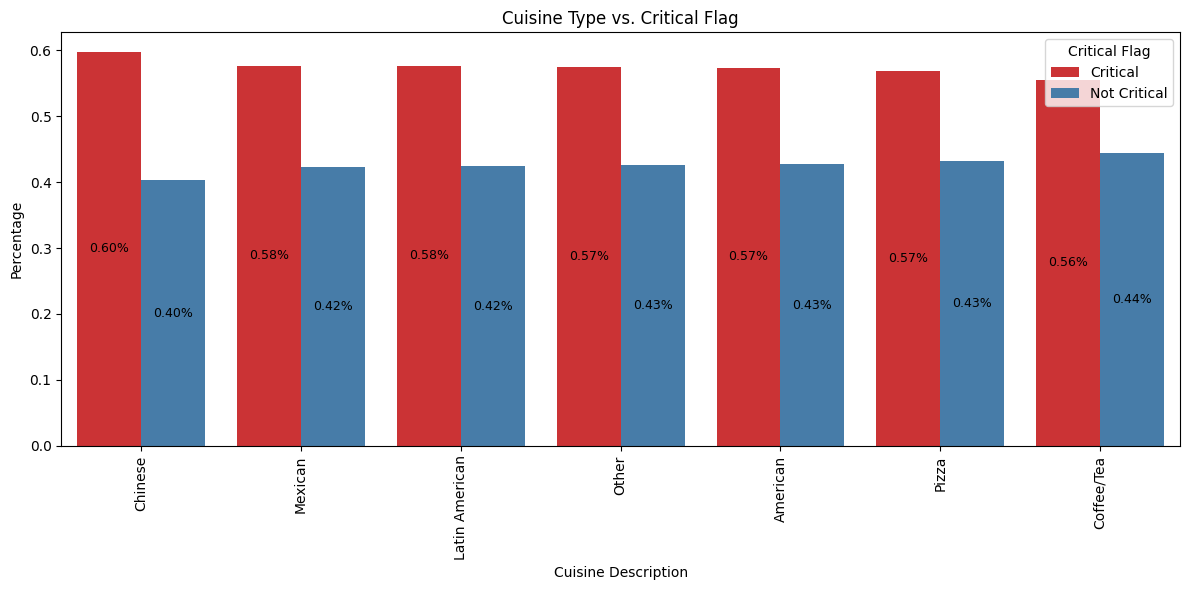

In [22]:
# Compute row-wise normalized crosstab (percentages per cuisine)
cuisine_crit_pct = pd.crosstab(
    gdf['cuisine_description'],
    gdf['critical_flag'],
    normalize='index'
).reset_index()

# Melt to long format
cuisine_crit_pct = cuisine_crit_pct.melt(
    id_vars='cuisine_description',
    var_name='critical_flag',
    value_name='percentage'
)

# Sort cuisines by total critical percentage (optional, for consistent order)
cuisine_order = (
    cuisine_crit_pct[cuisine_crit_pct['critical_flag'] == 'Critical']
    .sort_values('percentage', ascending=False)['cuisine_description']
)

# Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=cuisine_crit_pct,
    x='cuisine_description',
    y='percentage',
    hue='critical_flag',
    order=cuisine_order,
    palette='Set1'
)

# Annotate bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=9)

plt.title('Cuisine Type vs. Critical Flag')
plt.xlabel('Cuisine Description')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.legend(title='Critical Flag')
plt.tight_layout()
plt.show()

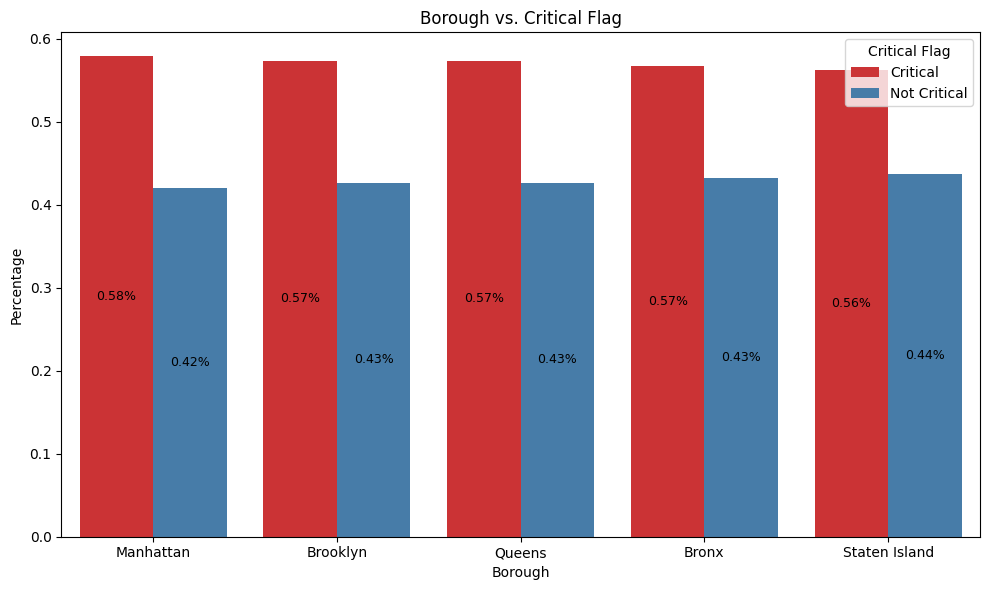

In [23]:
# Compute row-wise normalized crosstab (percentages per borough)
boro_crit_pct = pd.crosstab(
    gdf['boro'],
    gdf['critical_flag'],
    normalize='index'
).reset_index()

# Melt to long format
boro_crit_pct = boro_crit_pct.melt(
    id_vars='boro',
    var_name='critical_flag',
    value_name='percentage'
)

# Sort boroughs by critical percentage (optional)
boro_order = (
    boro_crit_pct[boro_crit_pct['critical_flag'] == 'Critical']
    .sort_values('percentage', ascending=False)['boro']
)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=boro_crit_pct,
    x='boro',
    y='percentage',
    hue='critical_flag',
    order=boro_order,
    palette='Set1'
)

# Annotate bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=9)

plt.title('Borough vs. Critical Flag')
plt.xlabel('Borough')
plt.ylabel('Percentage')
plt.legend(title='Critical Flag')
plt.tight_layout()
plt.show()

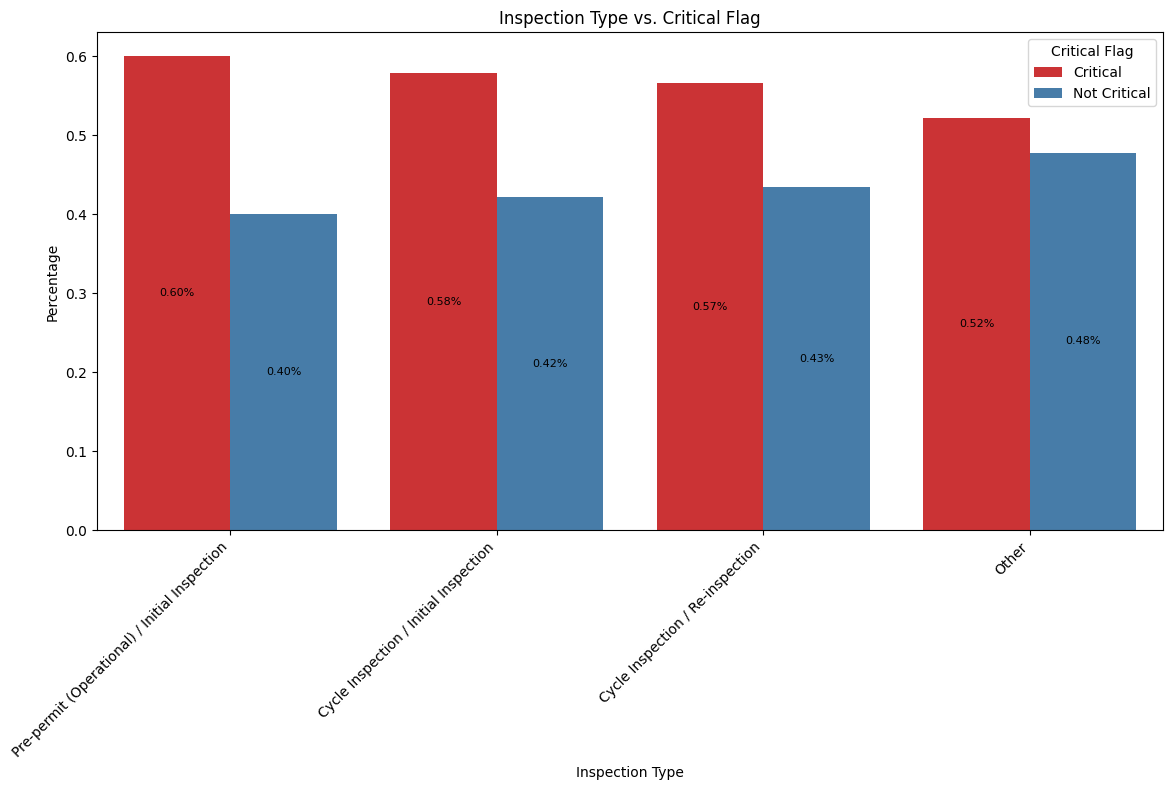

In [24]:
# Crosstab with row-wise normalization (percentages per inspection type)
inspection_type_crit_pct = pd.crosstab(
    gdf['inspection_type'],
    gdf['critical_flag'],
    normalize='index'
).reset_index()

# Melt to long format
inspection_type_crit_pct = inspection_type_crit_pct.melt(
    id_vars='inspection_type',
    var_name='critical_flag',
    value_name='percentage'
)

# Optional: Sort inspection types by critical percentage
insp_order = (
    inspection_type_crit_pct[inspection_type_crit_pct['critical_flag'] == 'Critical']
    .sort_values('percentage', ascending=False)['inspection_type']
)

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=inspection_type_crit_pct,
    x='inspection_type',
    y='percentage',
    hue='critical_flag',
    order=insp_order,
    palette='Set1'
)

# Annotate bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=8)

plt.title('Inspection Type vs. Critical Flag')
plt.xlabel('Inspection Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Critical Flag')
plt.tight_layout()
plt.show()


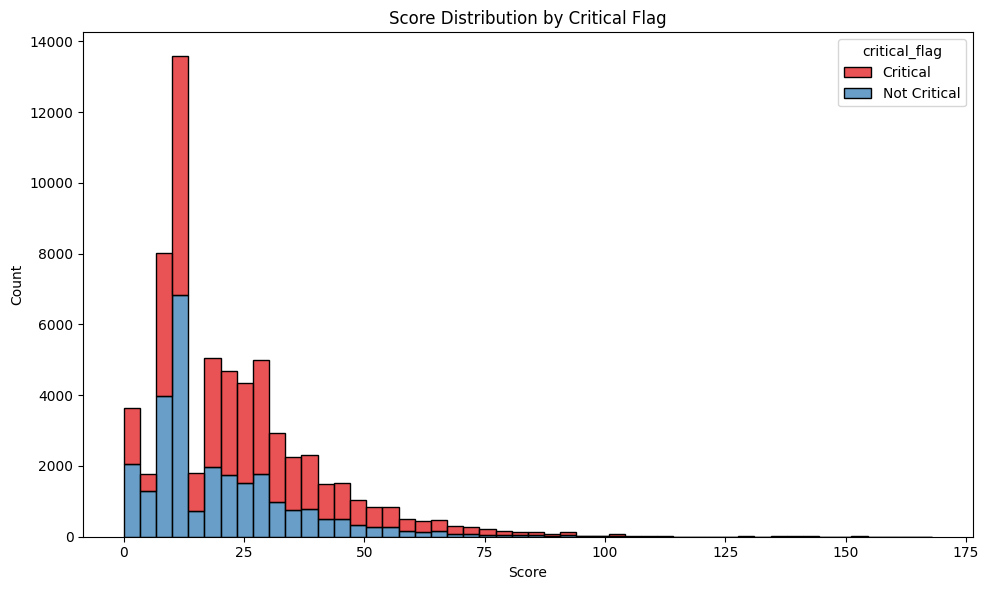

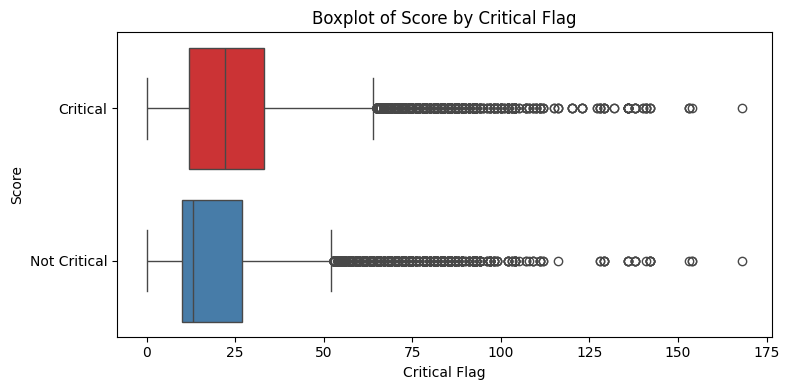

In [25]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=gdf.sort_values(by='critical_flag'),
    x='score',
    hue='critical_flag',
    bins=50,
    multiple='stack',
    palette='Set1',
    kde=False
)
plt.title('Score Distribution by Critical Flag')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=gdf.sort_values(by='critical_flag'),
    y='critical_flag',
    x='score',
    hue='critical_flag',
    palette='Set1'
)
plt.title('Boxplot of Score by Critical Flag')
plt.xlabel('Critical Flag')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

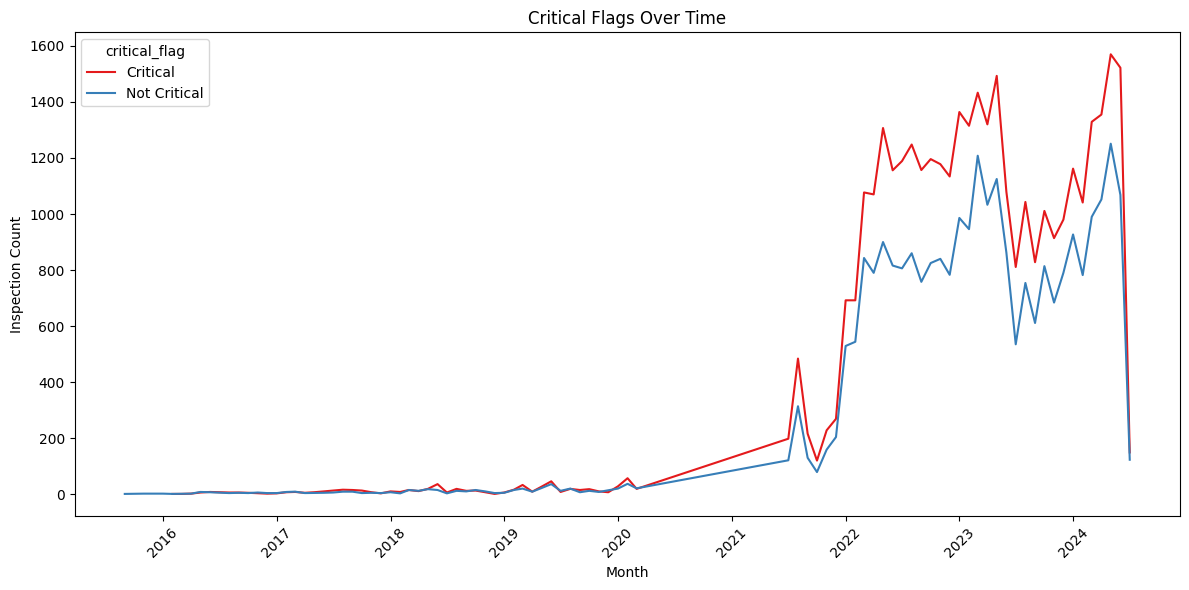

In [26]:
gdf['month'] = gdf['inspection_date'].dt.to_period('M').dt.to_timestamp()
monthly_trend = gdf.groupby(['month', 'critical_flag']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_trend.sort_values(['month', 'critical_flag'], ascending=[False, True]),
    x='month',
    y='count',
    hue='critical_flag',
    palette='Set1'
)
plt.title('Critical Flags Over Time')
plt.xlabel('Month')
plt.ylabel('Inspection Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

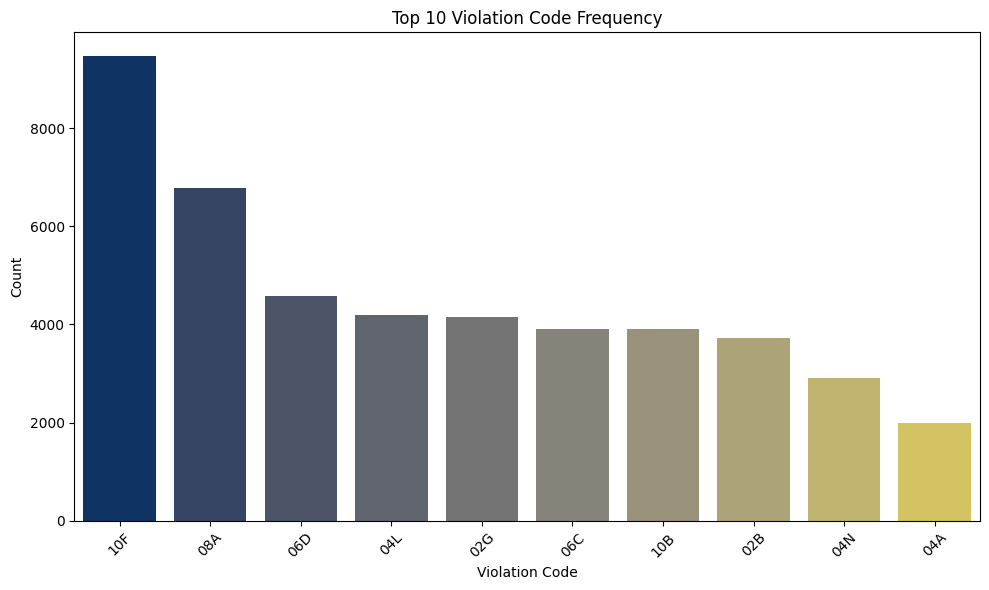

In [27]:
# Top 10 violations
violation_counts = gdf['violation_code'].value_counts().reset_index(name='count').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=violation_counts,
    x='violation_code',
    y='count',
    hue='violation_code',
    palette='cividis'
)
plt.title('Top 10 Violation Code Frequency')
plt.xlabel('Violation Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

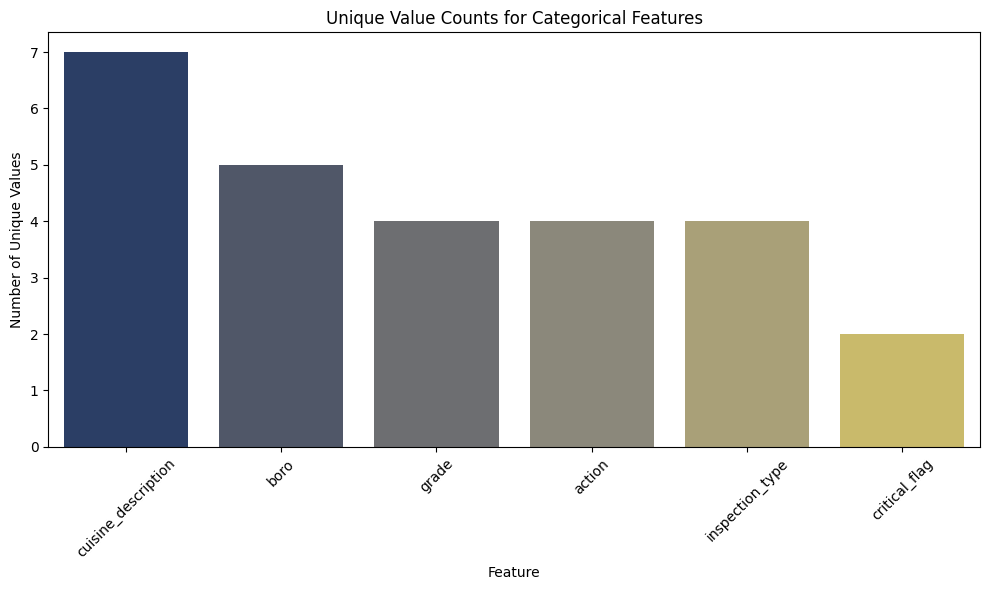

In [28]:
# Select categorical-like columns
not_cols = set(['inspection_id', 'dba', 'camis', 'building', 'street', 'zipcode', 'month', 'violation_code', 'violation_description'])
cat_cols = list(set(gdf.select_dtypes(include=['object', 'string', 'category']).columns) - not_cols)

# Count unique values
unique_counts = gdf[cat_cols].nunique().reset_index()
unique_counts.columns = ['feature', 'unique_count']
unique_counts = unique_counts.sort_values(by='unique_count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=unique_counts,
    x='feature',
    y='unique_count',
    hue='feature',
    palette='cividis'
)
plt.title('Unique Value Counts for Categorical Features')
plt.xlabel('Feature')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

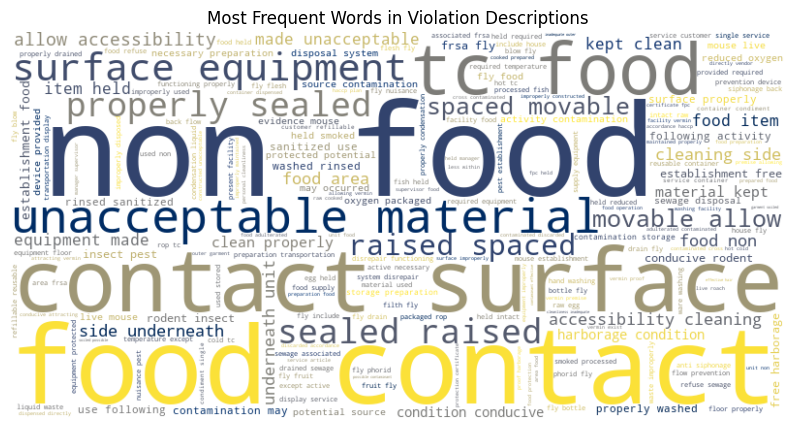

In [29]:
all_descriptions = ' '.join(gdf['violation_description'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='cividis'
).generate(all_descriptions)

# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Violation Descriptions')
plt.show()

### 🧠 Strategies

**General Feature Engineering**

To effectively handle categorical variables and maintain model performance, we adopt a hybrid encoding strategy based on feature cardinality, also the only metric feature `score`, displayed a log-normal distribution, which may cause problems models like the Logistic regression:

1. Features with **5 or fewer unique values** will be **one-hot encoded** to capture categorical distinctions without imposing ordinal bias.  
2. Features with **more than 5 unique values** will be **Bayesian target encoded** (i.e., mean encoding with smoothing) to preserve predictive signal while controlling dimensionality and overfitting risk.
3. Log or box-cox transform `score`.


---

**Text Feature Engineering**

To reduce noise and improve semantic signal from `violation_description`, we suggest the following steps before embedding or vectorization:

1. **Embedding Preparation:** The cleaned descriptions will be encoded using a pretrained Sentence Transformer (e.g., `all-MiniLM-L6-v2`) to capture semantic meaning.  
2. **Feature Integration:** The resulting embeddings can be directly fed into classifiers or combined with other structured features.  
3. **Derived Features from Raw Text:**  
   - **Length-based metrics:** Number of characters and words in the description.  
   - **Keyword intensity:** Count of “negative” or “severe” terms (e.g., *rodent*, *contaminated*, *vermin*, *infestation*).  
   - **Pattern flags:** TF-IDF scores or boolean indicators for presence of key term patterns (e.g., regex for “not properly”, “contaminated surface”, etc.).

This strategy helps replace the tightly coupled `violation_code` with a more interpretable and generalizable text representation, avoiding overfitting and enabling better model learning.

---

**Restaurant-Specific Feature Engineering**

To capture historical and temporal context about each restaurant, we propose creating the following features based on inspection history:

1. **Average Score (to date):** The mean violation score across all *past and current* inspections for the same restaurant (`camis`). This captures a smoothed quality signal over time, excluding any future data to prevent leakage.  
2. **Time Since Last Inspection:** Number of days since the restaurant's most recent previous inspection. For new establishments with only one record, this will be set to 0.  
3. **Inspection Count:** Total number of inspections completed for the restaurant up to and including the current record. This provides insight into the restaurant's monitoring frequency or history.

These features aim to enrich the model with restaurant-level behavioral trends, offering predictive signal beyond the current inspection’s context.

---

**Temporal Feature Engineering**

We will extract time-based features from the inspection date to capture potential seasonal and temporal patterns in violations:

- **Inspection Month:** Numeric month of the inspection (1–12).  
- **Inspection Year:** Year of the inspection.  
- **Inspection Season:** Categorical season (e.g., *Winter*, *Spring*, *Summer*, *Fall*) based on the inspection month.  

These features may help capture cyclical trends or inspection timing effects on violation risk.

---

**Geographical Feature Engineering**

To incorporate spatial context related to inspections, we suggest:

- **Inspection Density:** Number of inspections performed recently in the same borough or neighborhood, indicating regulatory intensity or area risk trends.

Spatial features can uncover geographic clusters or enforcement patterns relevant to risk prediction.